### Notebook for evaluating preliminary benchmarking params

This notebook shows our evaluation of the preliminary benchmarking experiments.
Note that the code assumes learning curves has been saved (NodeClassificationBeamHandlerSSL.save_training_curves = True)

In this experiment we evaluate all models on 1000 graphs. All graph properties and hyperparameters have been randomly sampled (mode 1).

The goal of the evaluation is to see if certain hyperparameters have a tendency to produce unstable or bad results, before running large scale experiments on many more graphs. In addition, the original GraphWorld experiments provide optimal hyperparameters for their models (mode 2) - if we see have similar optimal hyperparameters we have a strong argument for narrowing the hyperparameter ranges already now even though this has only been run on 1000 graphs.

Summary of our main findings and decision making:
- The downstream learning rate is sampled from [0.01, 0.001, 0.0001]. It seems 0.01 is favorable, while the lower learning rates can make the model not learn anything. All the original GraphWorld models also has the best learning rate set to 0.01. Hence we will in our future experiments narrow the search to sample from [0.003, 0.01, 0.03]
- As we in the future don't want to experiment with a downstream learning rate of 0.001 and 0.0001, we also examine results where the downstream learning rate is fixed to 0.01. Our findings here are:
    - The encoder hidden channels have been sampled from [4, 8, 16]. 16 generally seems to outperform the rest, and in all original GraphWorld models 16 is also the optimal value. Hence in future experiment we limit the sampling to be from [8, 16]
    - As we in the future don't want to experiment with hidden channels of 4, we also examine results where the hidden channels are betwen [8, 16]. Our findings here are:
        - The pretext weight generally perform best when set to 1, but as we expect this to be very different between models we leave the our ranges unchanged
        - The pretext epochs all roughly perform the same. Hence to lower the runtime of future experiments we only sample from [50, 100] instead of [50, 100, 150, 200, 250, 300]
        - The encoder layers seem to produce best results the lower it is. Similarly the original GraphWorld experiments set the optimal layers to 1 for all models. Hence we will only vary it between [1, 2] in future experiments rather than [1, 2, 3, 4]
        - Finally we examine the convergence of the models and the maximum patience (maximum amount of epochs before seeing an improvement). Again we filter away the experiments with hyperparamters we remove in the future:
            - We see that the majority of models have converged at epoch 250. Hence in future experiments we set maximum downstream epochs to 250.
            - We see that ca. 5% of models reach a maximum patience of 100. This is also what we fix it to in our experiments. Do note that this may result in some models stopping early, even though they could have performed better by increasing the patience. However, we choose to keep the patience at 100, because of the runtime complications.


Summary of changed hyperparameters for future experiments:
- Downstream learning rate: From [0.01, 0.001, 0.0001] to [0.003, 0.01, 0.03]
- Encoder hidden channels: From [4, 8 ,16] to [8, 16]
- Pretext epochs: From [50, 100, 150, 200, 250, 300] to [50, 100]
- Encoder layers: From [1, 2, 3, 4] to [1, 2]
- Downstream epochs: From 500 to 250

In [1]:
import pandas as pd
import json
from evaluation_utils import read_global_results, ssl_method_to_category, unpivot_ssl_model, unpivot_baseline_model
from constants import PRELIMINARY_DIR, MODE_1_PROCESSED_DIR, MODE_2_3_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, ENCODER_COLORS, SINGLE_ENCODER_MODELS, \
                        GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, MODE_1_LEARNING_CURVES_DIR
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
import itertools
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import patches

In [2]:
df = read_global_results(PRELIMINARY_DIR)
df2 = read_global_results(MODE_1_LEARNING_CURVES_DIR)

1.ndjson
concatenating
1.ndjson
2.ndjson
concatenating


In [3]:
def get_convergence(series):
    return np.array(series).argmax() + 1

In [4]:
def get_max_patience(series):
    best = float('-inf')
    max_patience = 0
    last_improvement = 0
    for i in series:
        if i > best:
            best = i
            if last_improvement > max_patience:
                max_patience = last_improvement
            last_improvement = 0
        else:
            last_improvement += 1
    return max_patience + 1

In [5]:
# Column constants
PRETEXT_LOSS = "pretext_losses"
DOWNSTREAM_TRAIN_LOSS = "downstream_train_losses"
DOWNSTREAM_VAL_LOSS = "downstream_val_losses"
DOWNSTREAM_TUNING_METRIC = "downstream_val_tuning_metrics"
TEST_METRIC = 'test_rocauc_ovr'
VAL_METRIC = 'val_rocauc_ovr'

BENCHMARK_PARAMS = ['train_downstream_lr', 'train_pretext_weight',
               'train_pretext_epochs', 'train_pretext_lr']
ENCODER_PARAMS = ['encoder_in_channels', 'encoder_hidden_channels', 'encoder_num_layers', 'encoder_dropout', 'encoder_heads']
ALL_PARAMS = BENCHMARK_PARAMS + ENCODER_PARAMS

### OLD PLOTS

In [17]:
# Plots histogram for the validation metric (tuning metric) of each hyperparam in PARAMS
# Must have is a list of tuples, specifying if certain other parameters should have specific values 
def plot_performance_for_params(PARAMS, must_have = []):
    values = defaultdict(lambda: defaultdict(list))
    for i in range(len(df)):
        for p in PARAMS:
            p_cols = [col for col in df if p in col]
            for p_model in p_cols:
                model = p_model.removesuffix(f'_{p}')
                must_have_accepted = True
                for mh_p, mh_v_list in must_have:
                    result = df[f'{model}_{mh_p}'].iloc[i]
                    if result not in mh_v_list:
                        must_have_accepted = False
                        break
                if must_have_accepted:
                    p_value = df[p_model].iloc[i]
                    result = df[f'{model}_{VAL_METRIC}'].iloc[i]
                    values[p][p_value].append(result)
        
    for k,v in values.items():
        for k2,v2 in v.items():
            plt.hist(v2, label=k2, alpha=0.5, weights=np.ones(len(v2)) / len(v2))
            plt.title(k)
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.legend()
        plt.show()

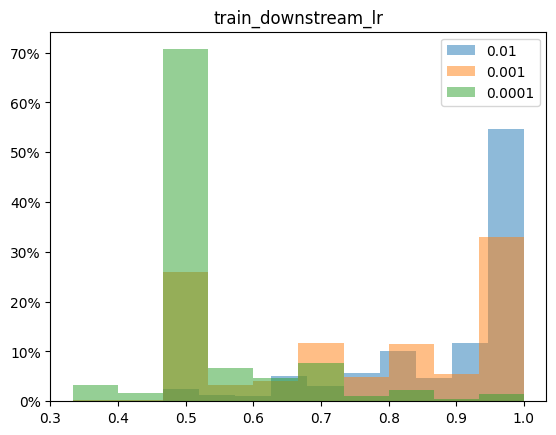

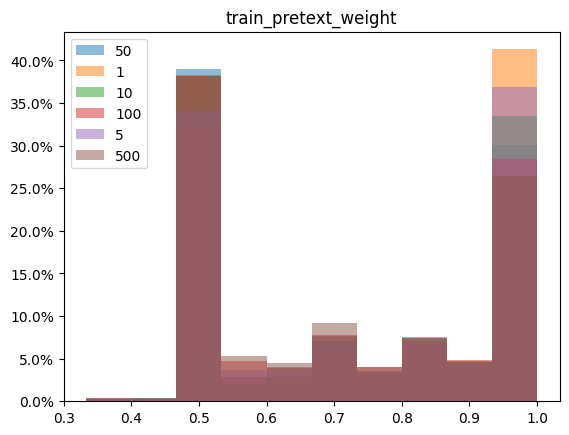

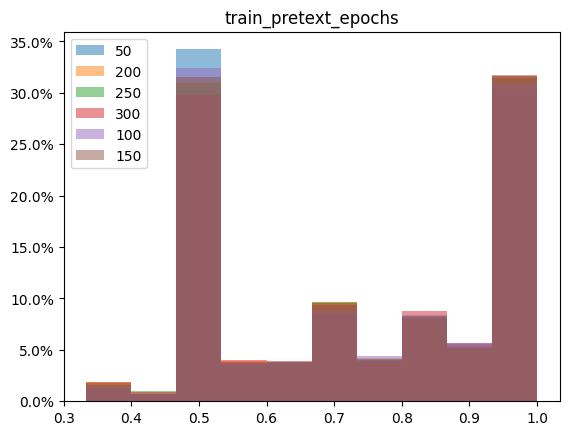

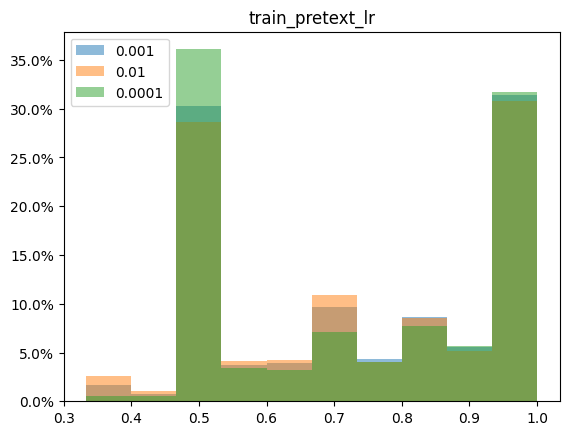

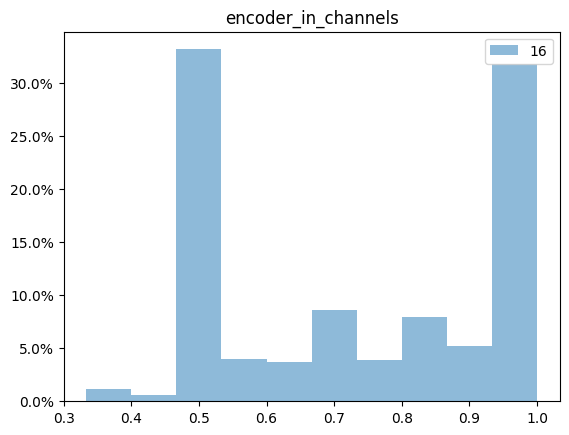

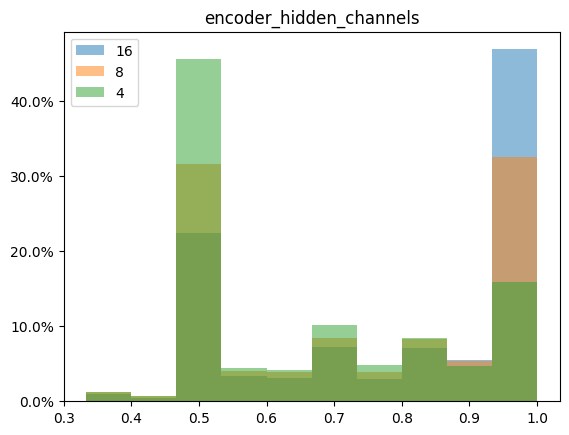

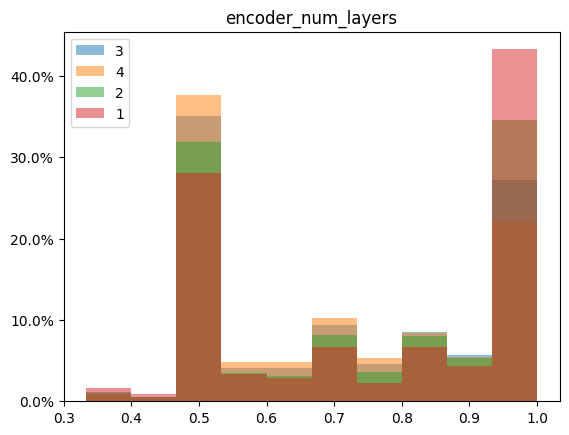

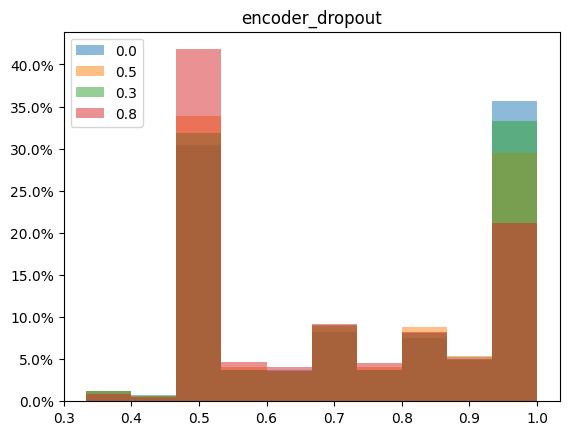

In [18]:
plot_performance_for_params(ALL_PARAMS)

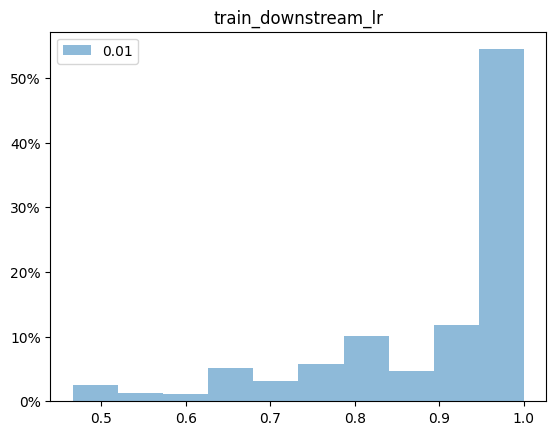

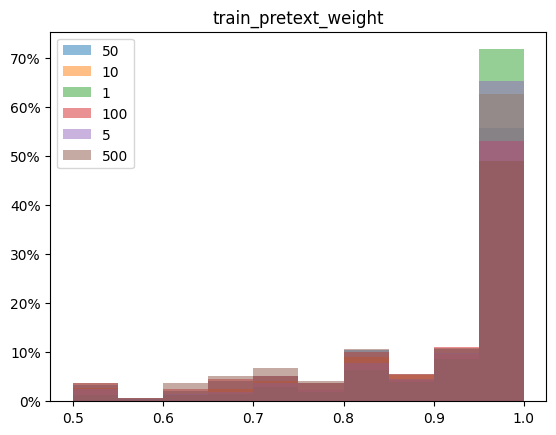

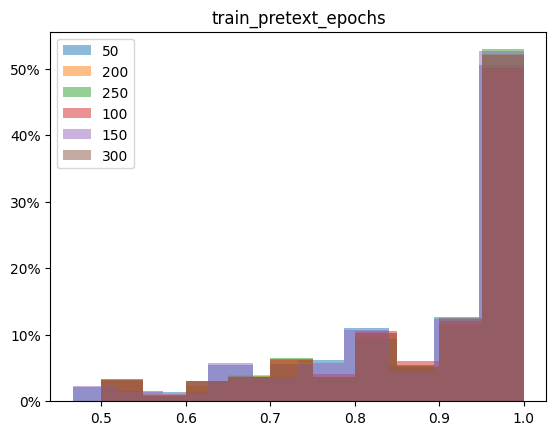

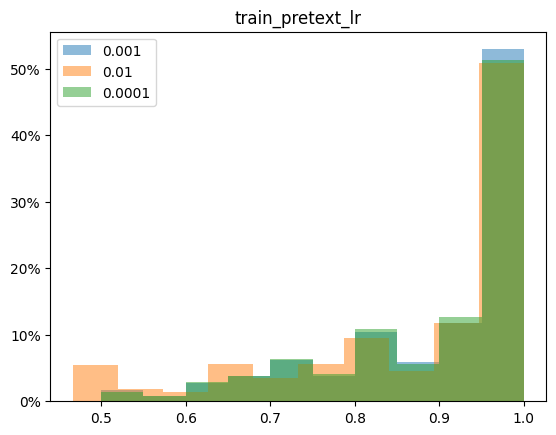

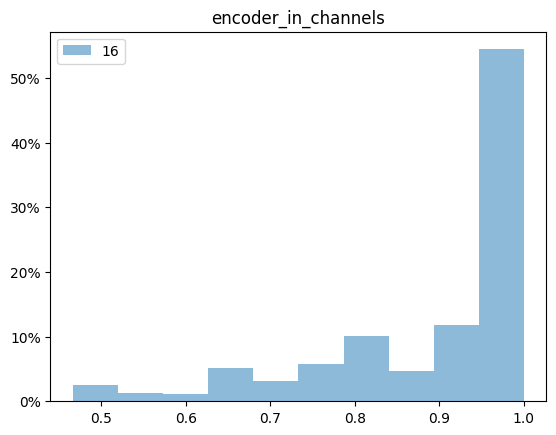

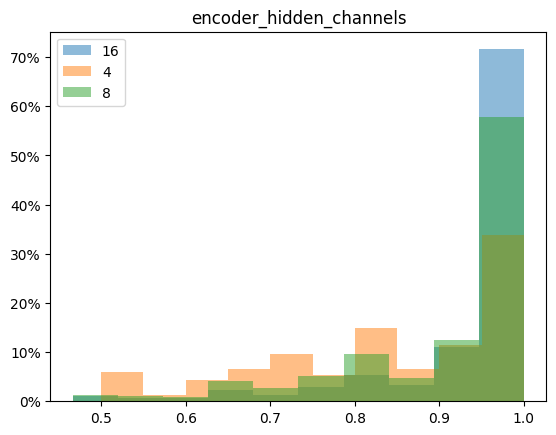

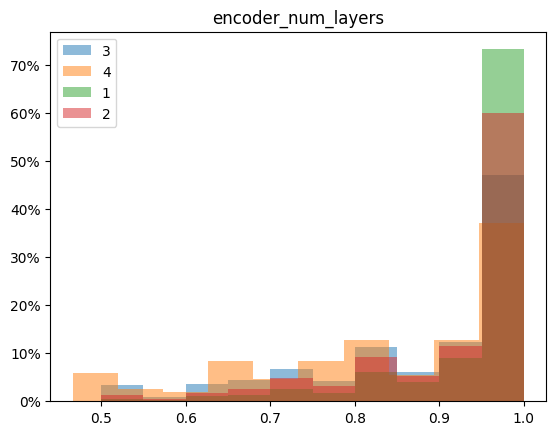

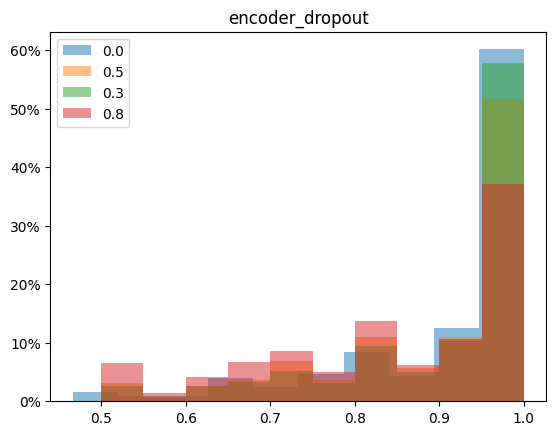

In [43]:
must_have = [('train_downstream_lr', [0.01])]
plot_performance_for_params(ALL_PARAMS, must_have=must_have)

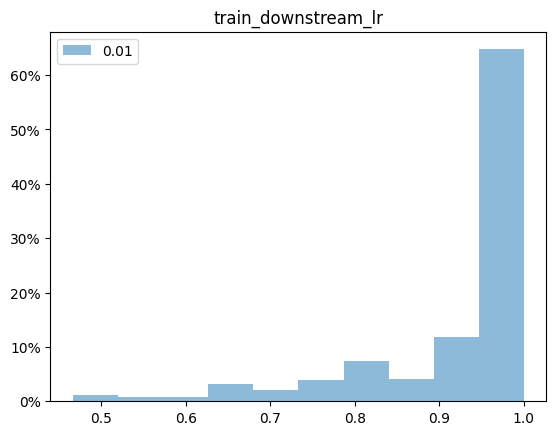

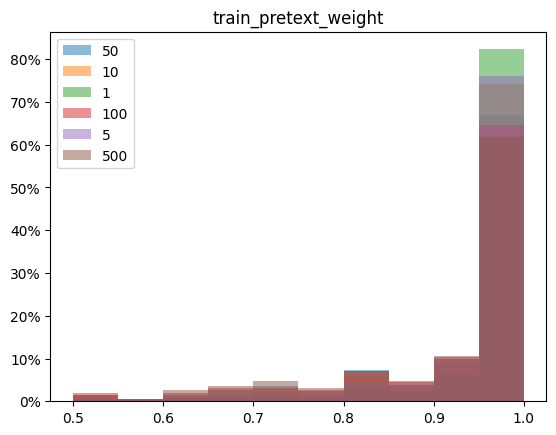

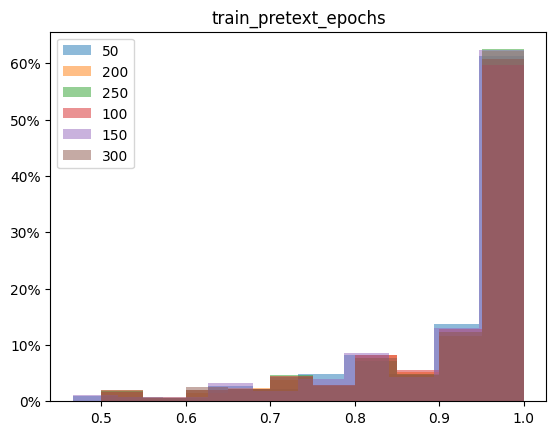

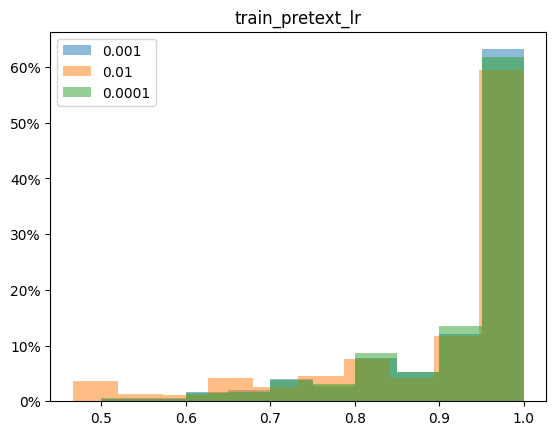

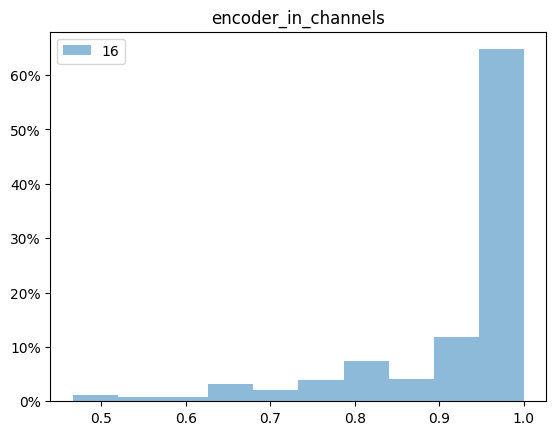

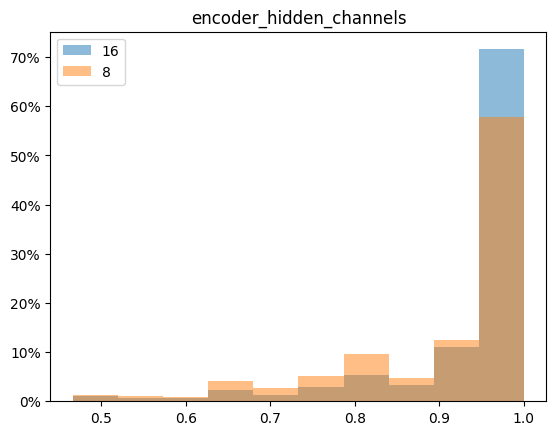

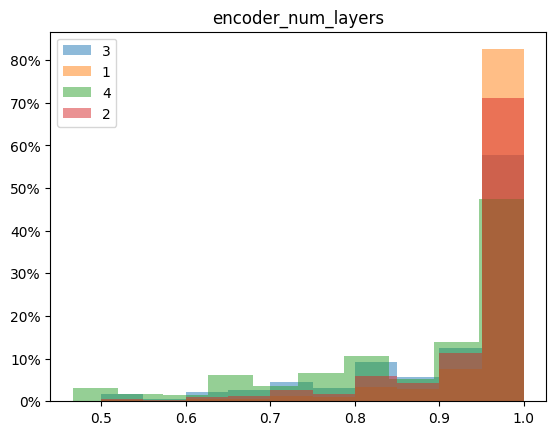

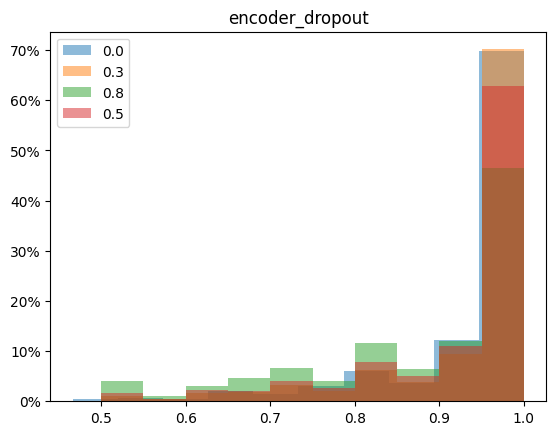

In [44]:
must_have.append(('encoder_hidden_channels', [8, 16]))
plot_performance_for_params(ALL_PARAMS, must_have=must_have)

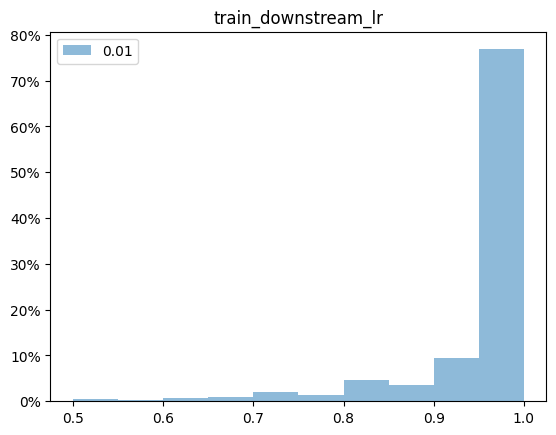

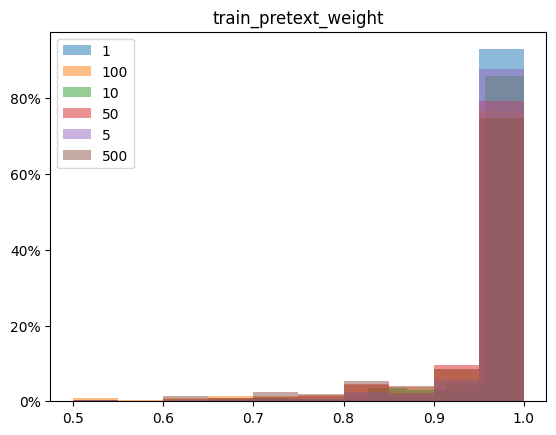

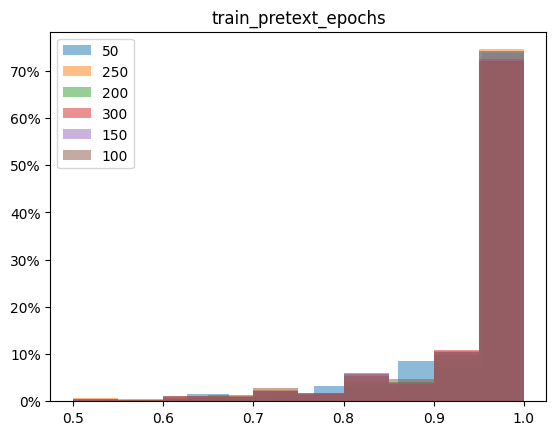

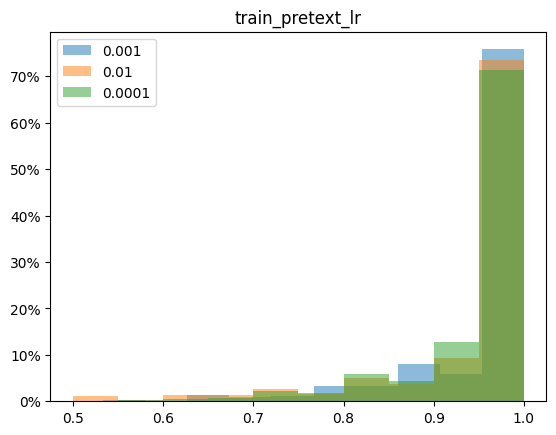

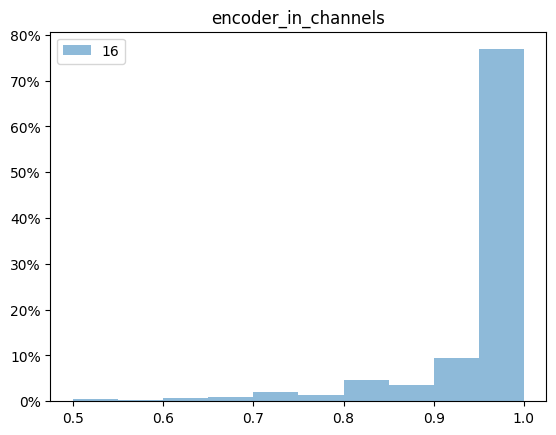

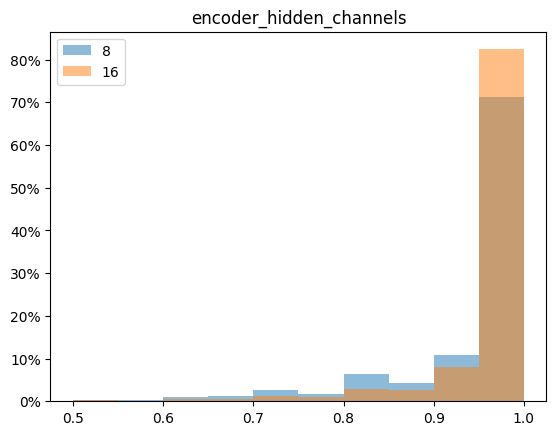

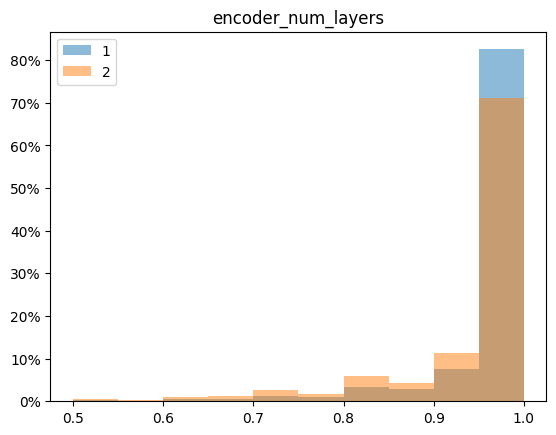

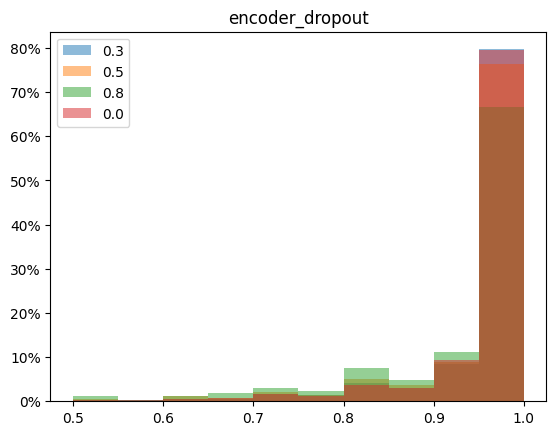

In [45]:
must_have.append(('encoder_num_layers', [1,2]))
plot_performance_for_params(ALL_PARAMS, must_have=must_have)

In [72]:
# Evaluating downstream best epoch (convergence) and maximum patience combined for each training scheme
def plot_convergence_and_patience(must_have=[], bins=None):
    cols = [col for col in df if DOWNSTREAM_TUNING_METRIC in col]
    best_epoch_JL, max_patience_JL = [], []
    best_epoch_PF, max_patience_PF = [], []
    best_epoch_URL, max_patience_URL = [], []
    for col in cols:
        for i in range(len(df)):
            model = col.removesuffix(f'_{DOWNSTREAM_TUNING_METRIC}')
            must_have_accepted = True
            for mh_p, mh_v_list in must_have:
                result = df[f'{model}_{mh_p}'].iloc[i]
                if result not in mh_v_list:
                    must_have_accepted = False
                    break
            if must_have_accepted:
                metric_list = df[col].iloc[i]
                if metric_list is not None:
                    if "JL" in model:
                        best_epoch_JL.append(get_convergence(metric_list, 100))
                        max_patience_JL.append(get_max_patience(metric_list))
                    elif "PF" in model:
                        best_epoch_PF.append(get_convergence(metric_list, 100))
                        max_patience_PF.append(get_max_patience(metric_list))
                    elif "URL" in model:
                        best_epoch_URL.append(get_convergence(metric_list, 100))
                        max_patience_URL.append(get_max_patience(metric_list))
        
    plt.hist(best_epoch_JL, bins=bins, label="JL", alpha=0.5, weights=np.ones(len(best_epoch_JL)) / len(best_epoch_JL))
    plt.hist(best_epoch_PF, bins=bins, label="PF", alpha=0.5, weights=np.ones(len(best_epoch_PF)) / len(best_epoch_PF))
    plt.hist(best_epoch_URL, bins=bins, label="URL", alpha=0.5, weights=np.ones(len(best_epoch_URL)) / len(best_epoch_URL))
    plt.title("Training schemes best epoch")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()
    plt.show()

    plt.hist(max_patience_JL, bins=bins, label="JL", alpha=0.5, weights=np.ones(len(max_patience_JL)) / len(max_patience_JL))
    plt.hist(max_patience_PF, bins=bins, label="PF", alpha=0.5, weights=np.ones(len(max_patience_PF)) / len(max_patience_PF))
    plt.hist(max_patience_URL, bins=bins, label="URL", alpha=0.5, weights=np.ones(len(max_patience_URL)) / len(max_patience_URL))
    plt.title("Training schemes maximum patience")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()
    plt.show()


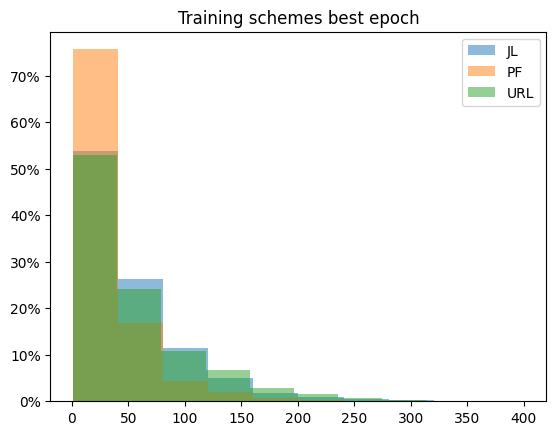

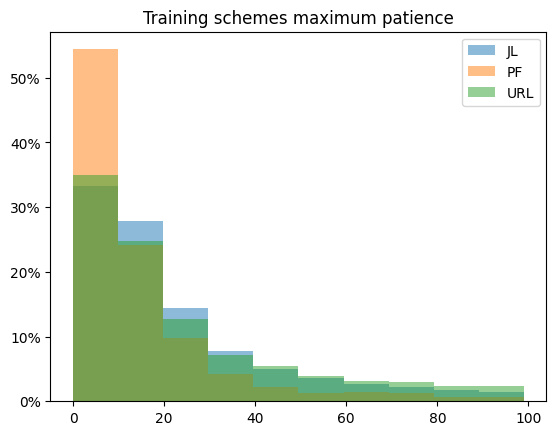

In [82]:
plot_convergence_and_patience(must_have=must_have)

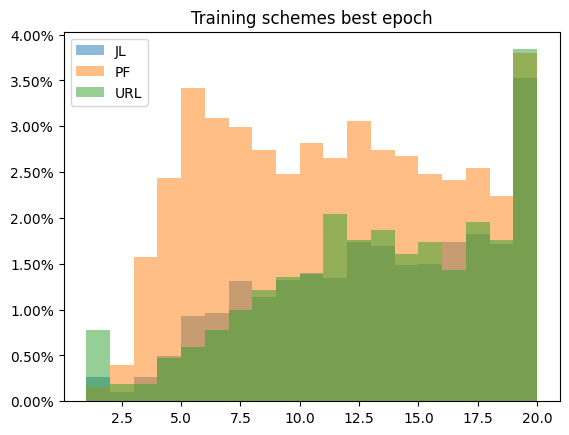

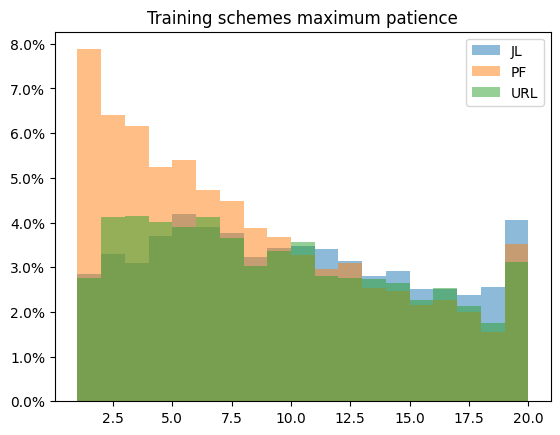

In [ ]:
plot_convergence_and_patience(must_have=must_have, bins=range(1,21))

### NEW PLOTS

In [6]:
df_ssl = unpivot_ssl_model(df=df, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES, include_tuning_metric=True)
df_ssl2 = unpivot_ssl_model(df=df2, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES, include_tuning_metric=True)
df_baselines = unpivot_baseline_model(df=df, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES, include_tuning_metric=True)

ALL_PARAMS = ['train_downstream_lr', 'encoder_hidden_channels', 'encoder_num_layers', 'train_pretext_weight','train_pretext_epochs', 'train_pretext_lr'] + \
                ['encoder_dropout', 'encoder_heads']

In [13]:
df_ssl.rename(columns={TEST_METRIC:"ROC AUC"}, inplace=True)
df_ssl2.rename(columns={TEST_METRIC:"ROC AUC"}, inplace=True)
df_baselines.rename(columns={TEST_METRIC:"ROC AUC"}, inplace=True)

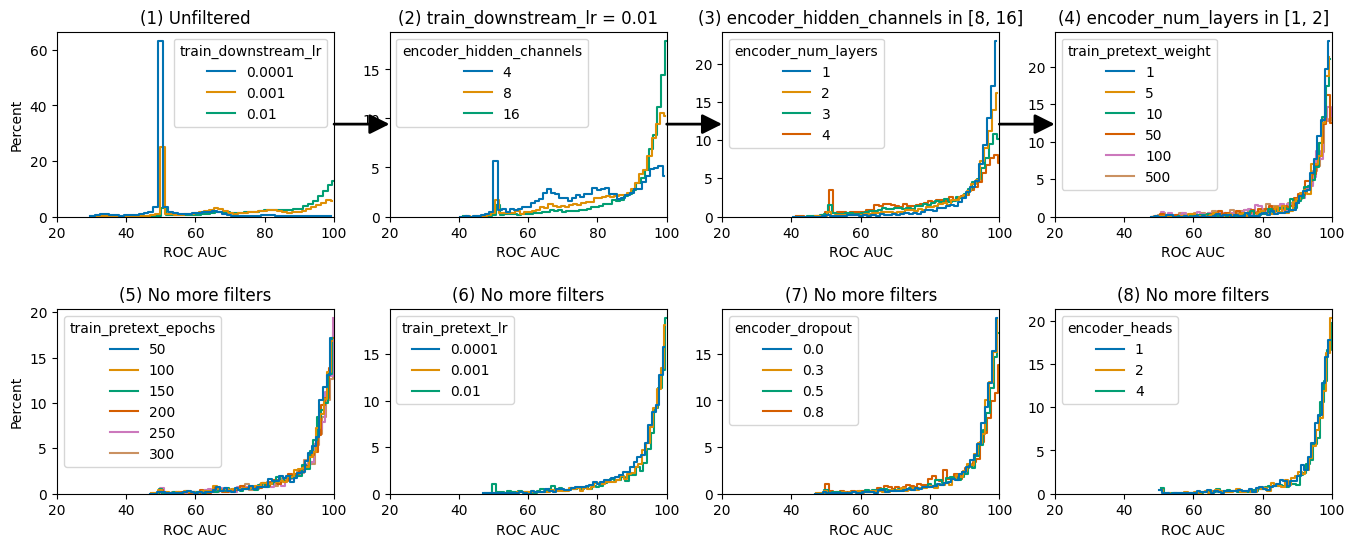

<AxesSubplot: title={'center': 'Aggregated performance'}, xlabel='ROC AUC', ylabel='Percent'>

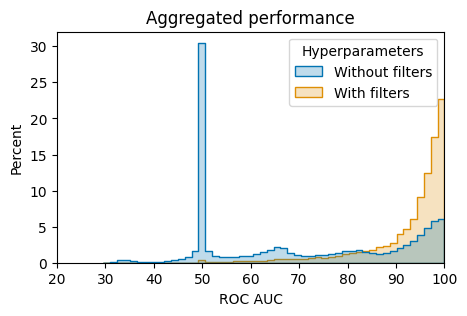

In [137]:
fig=plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(2, len(ALL_PARAMS)//2)
gs.update(left=0.1, right=0.95, wspace=0.2, hspace=0.5)
df_ssl_temp = df_ssl.copy()
axes_dict = {}
for i, param in enumerate(ALL_PARAMS):
    if i >= 4:
        j = 1
        i_2 = i - 4
    else:
        j = 0
        i_2 = i

    ax=plt.subplot(gs[j,i_2])
    axes_dict[i] = ax
    ax.set_xlim(20, 100)
    sns.histplot(data=df_ssl_temp, x="ROC AUC", hue=param, stat='percent', bins=50, hue_order=sorted(df_ssl_temp[param].dropna().unique()),
                element='step', fill=False, common_norm=False, palette='colorblind', ax=ax, legend=True, multiple='dodge')
    if param == 'train_downstream_lr':
        ax.set_title(f"({i+1}) Unfiltered")
        df_ssl_temp = df_ssl_temp[df_ssl_temp['train_downstream_lr'] == 0.01]
    elif param == 'encoder_hidden_channels':
        ax.set_title(f"({i+1}) train_downstream_lr = 0.01")
        df_ssl_temp = df_ssl_temp[df_ssl_temp['encoder_hidden_channels'].isin([8,16])]
    elif param == 'encoder_num_layers':
        ax.set_title(f"({i+1}) encoder_hidden_channels in [8, 16]")
        df_ssl_temp = df_ssl_temp[df_ssl_temp['encoder_num_layers'].isin([1,2])]
    elif param == 'train_pretext_weight':
        ax.set_title(f"({i+1}) encoder_num_layers in [1, 2]")
    else:
        ax.set_title(f"({i+1}) No more filters")

    if i_2 != 0:
        ax.set_ylabel("")


for (a,b) in [(0,1), (1,2), (2,3)]:
    # Add line from one subplot to the other
    xyA = [100, axes_dict[a].get_ylim()[1]/2]
    #axes_dict[0].plot(*xyA, "o")
    xyB = [20, axes_dict[b].get_ylim()[1]/2]
    #axes_dict[1].plot(*xyB, "o")
    transFigure = fig.transFigure.inverted()
    coord1 = transFigure.transform(axes_dict[a].transData.transform(xyA))
    coord2 = transFigure.transform(axes_dict[b].transData.transform(xyB))
    arrow = patches.FancyArrowPatch(
        coord1,  # posA
        coord2,  # posB
        shrinkA=0,  # so tail is exactly on posA (default shrink is 2)
        shrinkB=0,  # so head is exactly on posB (default shrink is 2)
        transform=fig.transFigure,
        color="black",
        arrowstyle="-|>",  # "normal" arrow
        mutation_scale=30,  # controls arrow head size
        linewidth=2,
    )
    fig.patches.append(arrow)
plt.show()

df_ssl['Hyperparameters'] = "Without filters"
df_ssl_temp['Hyperparameters'] = "With filters"
df_combined = pd.concat([df_ssl, df_ssl_temp], keys=['df_ssl', 'df_ssl_temp'], ignore_index=True)


fig=plt.figure(figsize=(5,3))
plt.xlim(20, 100)
plt.title("Aggregated performance")
sns.histplot(data=df_combined, x="ROC AUC", stat='percent', bins=50, hue='Hyperparameters', hue_order=["Without filters", "With filters"],
             fill=True, common_norm=False, legend=True, palette="colorblind", element="step")


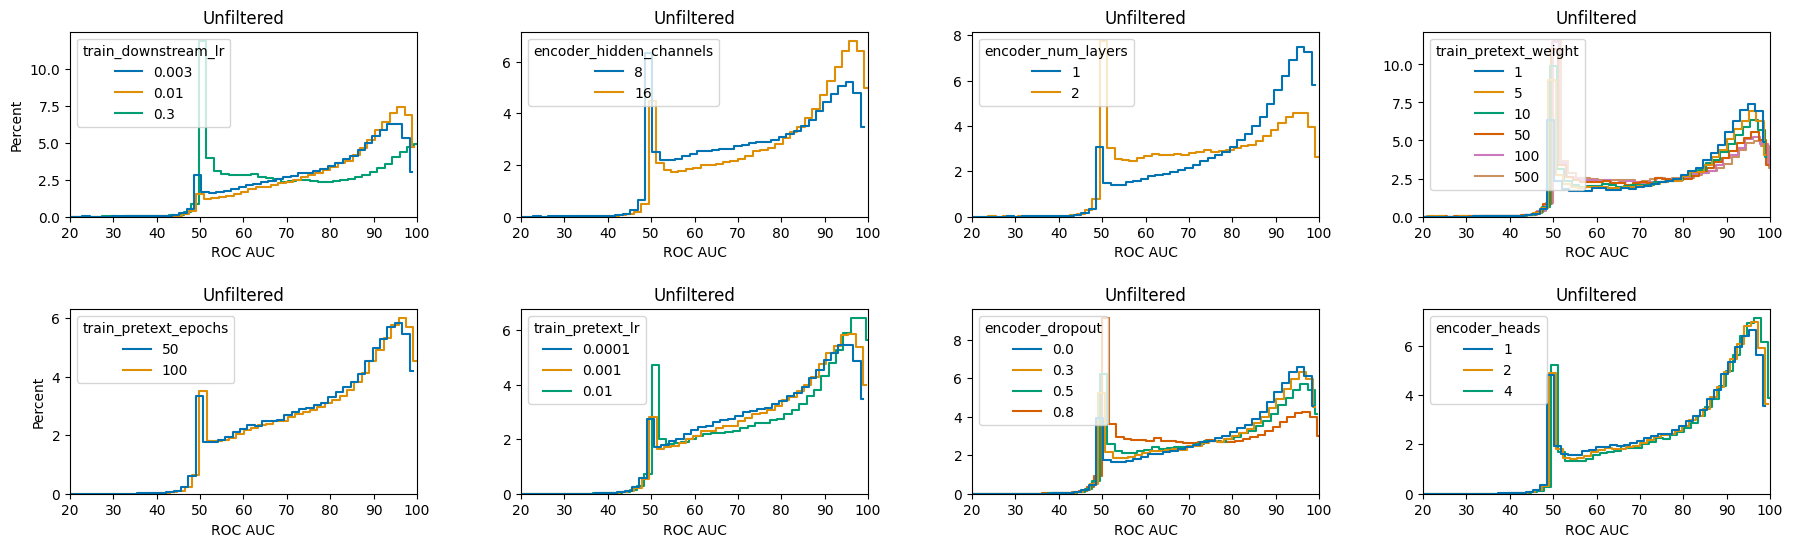

In [103]:
fig=plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(2, len(ALL_PARAMS)//2)
gs.update(left=0.1, right=0.95, wspace=0.3, hspace=0.5)
df_ssl2
axes_dict = {}
for i, param in enumerate(ALL_PARAMS):
    if i >= 4:
        j = 1
        i_2 = i - 4
    else:
        j = 0
        i_2 = i

    ax=plt.subplot(gs[j,i_2])
    axes_dict[i] = ax
    ax.set_xlim(20, 100)
    sns.histplot(data=df_ssl2, x="ROC AUC", hue=param, stat='percent', bins=50, hue_order=sorted(df_ssl2[param].dropna().unique()),
                element='step', fill=False, common_norm=False, palette='colorblind', ax=ax, legend=True, multiple='dodge')
    ax.set_title("Unfiltered")

    if i_2 != 0:
        ax.set_ylabel("")
plt.show()

In [104]:
df_ssl_temp['best epoch'] = df_ssl_temp['downstream_val_tuning_metrics'].apply(lambda x: get_convergence(x))
df_ssl_temp['max epoch before improvement'] = df_ssl_temp['downstream_val_tuning_metrics'].apply(lambda x: get_max_patience(x))
df_ssl_temp['perfect validation score'] = df_ssl_temp['downstream_val_tuning_metrics'].apply(lambda x: 1.0 in x)

df_baselines['best epoch'] = df_baselines['downstream_val_tuning_metrics'].apply(lambda x: get_convergence(x))
df_baselines['max epoch before improvement'] = df_baselines['downstream_val_tuning_metrics'].apply(lambda x: get_max_patience(x))
df_baselines['perfect validation score'] = df_baselines['downstream_val_tuning_metrics'].apply(lambda x: 1.0 in x)

df_ssl2['best epoch'] = df_ssl2['downstream_val_tuning_metrics'].apply(lambda x: get_convergence(x))
df_ssl2['max epoch before improvement'] = df_ssl2['downstream_val_tuning_metrics'].apply(lambda x: get_max_patience(x))
df_ssl2['perfect validation score'] = df_ssl2['downstream_val_tuning_metrics'].apply(lambda x: 1.0 in x)

In [105]:
df_baselines2 = df_baselines.copy()
df_baselines2 = df_baselines2[df_baselines2['train_downstream_lr'] == 0.01]
df_baselines2 = df_baselines2[df_baselines2['encoder_hidden_channels'].isin([8,16])]
df_baselines2 = df_baselines2[df_baselines2['encoder_num_layers'].isin([1,2])]

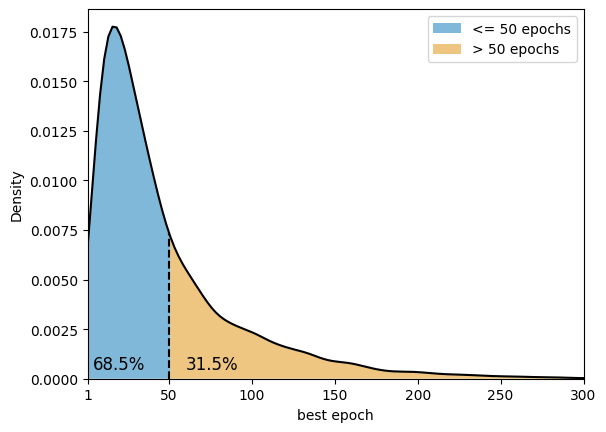

In [108]:
# Best epoch for SSL models
fig, ax = plt.subplots()
sns.kdeplot(df_ssl_temp['best epoch'], color='black', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

split = 50
ax.vlines(split, 0, np.interp(split, xs, ys), color='black', ls='--')
p1 = ax.fill_between(xs, 0, ys, where=xs-1 < split, facecolor=sns.color_palette("colorblind")[0], alpha=0.5)
p2 = ax.fill_between(xs, 0, ys, where=xs > split, interpolate=True, facecolor=sns.color_palette("colorblind")[1], alpha=0.5)

perc = len(df_ssl_temp[df_ssl_temp['best epoch'] > 50]) / len(df_ssl_temp) * 100
ax.annotate("{:.1f}%".format(perc), (60,0.0005), fontsize=12)
ax.annotate("{:.1f}%".format(100-perc), (4,0.0005), fontsize=12)

ax.set_xlim(1, 300)
plt.xticks([1, 50, 100, 150, 200, 250, 300])
plt.legend([p1, p2],['<= 50 epochs', '> 50 epochs'])
plt.show()

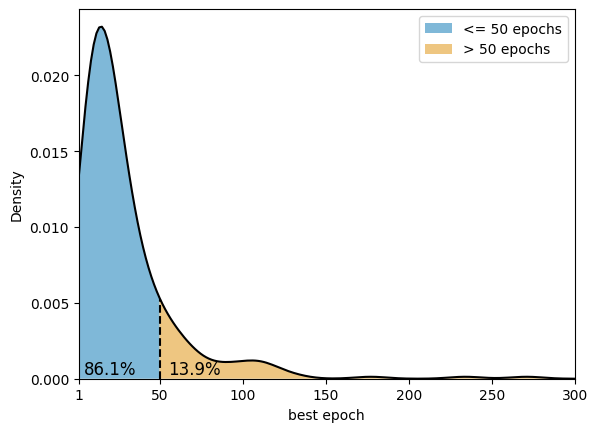

In [132]:
# Best epoch for baselines
fig, ax = plt.subplots()
sns.kdeplot(df_baselines2['best epoch'], color='black', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

split = 50
ax.vlines(split, 0, np.interp(split, xs, ys), color='black', ls='--')
p1 = ax.fill_between(xs, 0, ys, where=xs-1 < split, facecolor=sns.color_palette("colorblind")[0], alpha=0.5)
p2 = ax.fill_between(xs, 0, ys, where=xs+1 > split, interpolate=True, facecolor=sns.color_palette("colorblind")[1], alpha=0.5)

perc = len(df_baselines2[df_baselines2['best epoch'] > 50]) / len(df_baselines2) * 100
ax.annotate("{:.1f}%".format(perc), (55,0.0003), fontsize=12)
ax.annotate("{:.1f}%".format(100-perc), (4,0.0003), fontsize=12)

ax.set_xlim(1, 300)
plt.xticks([1, 50, 100, 150, 200, 250, 300])
plt.legend([p1, p2],['<= 50 epochs', '> 50 epochs'])
plt.show()

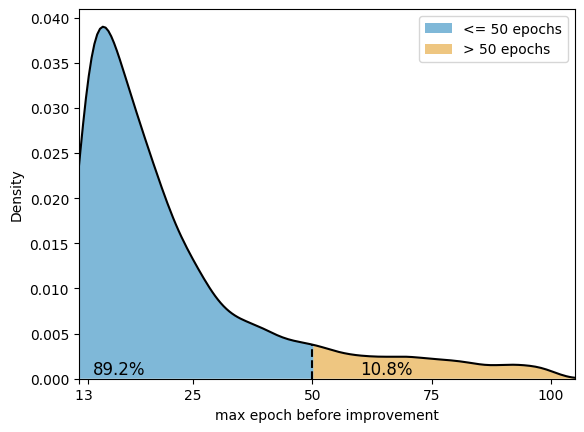

In [133]:
# Max epoch before improvement for SSL models
fig, ax = plt.subplots()
sns.kdeplot(df_ssl_temp['max epoch before improvement'], color='black', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

split = 50
ax.vlines(split, 0, np.interp(split, xs, ys), color='black', ls='--')
p1 = ax.fill_between(xs, 0, ys, where=xs-.4 < split, facecolor=sns.color_palette("colorblind")[0], alpha=0.5)
p2 = ax.fill_between(xs, 0, ys, where=xs > split, interpolate=True, facecolor=sns.color_palette("colorblind")[1], alpha=0.5)

perc = len(df_ssl_temp[df_ssl_temp['max epoch before improvement'] > 50]) / len(df_ssl_temp) * 100
ax.annotate("{:.1f}%".format(perc), (60,0.0005), fontsize=12)
ax.annotate("{:.1f}%".format(100-perc), (4,0.0005), fontsize=12)

ax.set_xlim(1, 105)
plt.xticks([1, 3, 25, 50, 75, 100])
plt.legend([p1, p2],['<= 50 epochs', '> 50 epochs'])
plt.show()

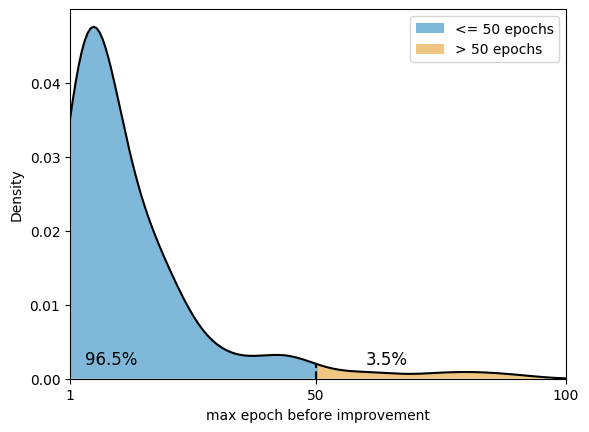

In [134]:
# Max epoch before improvement for baselines
x = df_baselines2['max epoch before improvement']
fig, ax = plt.subplots()
sns.kdeplot(x, color='black', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

split = 50
ax.vlines(split, 0, np.interp(split, xs, ys), color='black', ls='--')
p1 = ax.fill_between(xs, 0, ys, where=xs-.5 < split, facecolor=sns.color_palette("colorblind")[0], alpha=0.5)
p2 = ax.fill_between(xs, 0, ys, where=xs > split, interpolate=True, facecolor=sns.color_palette("colorblind")[1], alpha=0.5)

perc = len(df_baselines2[df_baselines2['max epoch before improvement'] > 50]) / len(df_baselines2) * 100
ax.annotate("{:.1f}%".format(perc), (60,0.002), fontsize=12)
ax.annotate("{:.1f}%".format(100-perc), (4,0.002), fontsize=12)

ax.set_xlim(1, 100)
plt.xticks([1, 50, 100])
plt.legend([p1, p2],['<= 50 epochs', '> 50 epochs'])
plt.show()

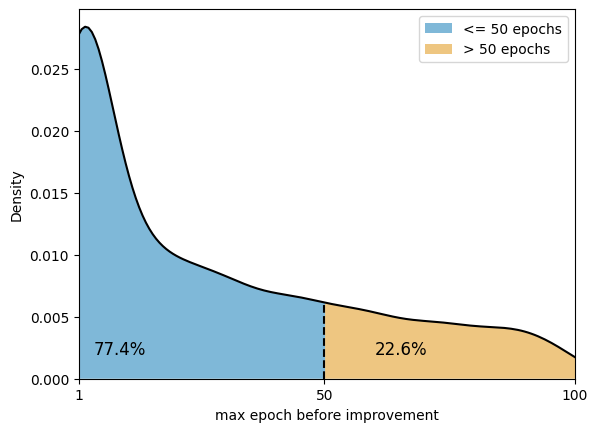

In [135]:
# Max epoch before improvement for baselines
x = df_baselines['max epoch before improvement']
fig, ax = plt.subplots()
sns.kdeplot(x, color='black', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

split = 50
ax.vlines(split, 0, np.interp(split, xs, ys), color='black', ls='--')
p1 = ax.fill_between(xs, 0, ys, where=xs-.5 < split, facecolor=sns.color_palette("colorblind")[0], alpha=0.5)
p2 = ax.fill_between(xs, 0, ys, where=xs > split, interpolate=True, facecolor=sns.color_palette("colorblind")[1], alpha=0.5)

perc = len(df_baselines[df_baselines['max epoch before improvement'] > 50]) / len(df_baselines) * 100
ax.annotate("{:.1f}%".format(perc), (60,0.002), fontsize=12)
ax.annotate("{:.1f}%".format(100-perc), (4,0.002), fontsize=12)

ax.set_xlim(1, 100)
plt.xticks([1, 50, 100])
plt.legend([p1, p2],['<= 50 epochs', '> 50 epochs'])
plt.show()

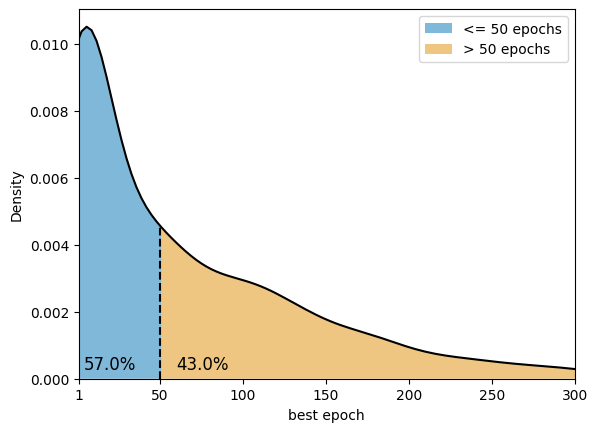

In [136]:
# Best epoch for baselines
fig, ax = plt.subplots()
sns.kdeplot(df_baselines['best epoch'], color='black', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

split = 50
ax.vlines(split, 0, np.interp(split, xs, ys), color='black', ls='--')
p1 = ax.fill_between(xs, 0, ys, where=xs-1 < split, facecolor=sns.color_palette("colorblind")[0], alpha=0.5)
p2 = ax.fill_between(xs, 0, ys, where=xs > split, interpolate=True, facecolor=sns.color_palette("colorblind")[1], alpha=0.5)

perc = len(df_baselines[df_baselines['best epoch'] > 50]) / len(df_baselines) * 100
ax.annotate("{:.1f}%".format(perc), (60,0.0003), fontsize=12)
ax.annotate("{:.1f}%".format(100-perc), (4,0.0003), fontsize=12)

ax.set_xlim(1, 300)
plt.xticks([1, 50, 100, 150, 200, 250, 300])
plt.legend([p1, p2],['<= 50 epochs', '> 50 epochs'])
plt.show()